## Section 1: Project Configuration

In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

In [2]:
# Load the cleaned dataset
df = pd.read_csv("songs_cleaned.csv", encoding="latin-1")
df.head() 

,track_name,artist(s)_name,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",125,80,89,83,31,0,8,4
1,LALA,Myke Towers,92,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,138,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,170,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,144,65,23,80,14,63,11,6


In [3]:
# Extract the audio features (column 2 and onwards)
audio_feature_cols = df.columns[2:10]   

X = df[audio_feature_cols].values

audio_feature_cols, X.shape

(Index(['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%',
        'instrumentalness_%', 'liveness_%', 'speechiness_%'],
       dtype='object'),
 (953, 8))

## Section 2: Find K value (Silhouette and Elbow method)

In [11]:
# Range of K values we want to test
k_values = range(2, 11) 

# Lists to store metrics
inertias = [] # Elbow method (wcss)           
sil_scores = [] # Sillhouette method

# Runs for each value of k we are testing
for k in k_values:

    # Pipeline to apply the k-means clustering to the data
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('kmeancl', KMeans(n_clusters=k, random_state=0))
    ])

    labels_k = pipe.fit_predict(X)
    
    # Elbow inertia/wcss
    inertias.append(pipe.named_steps['kmeancl'].inertia_)
    
    # Silhouette score
    score_k = silhouette_score(X, labels_k)
    sil_scores.append(score_k)
    
    print(f"k = {k}, inertia = {pipe.named_steps['kmeancl'].inertia_:.2f}, silhouette = {score_k:.4f}")

k = 2, inertia = 6348.17, silhouette = 0.2355
k = 3, inertia = 5702.99, silhouette = 0.1645
k = 4, inertia = 5092.90, silhouette = 0.1517
k = 5, inertia = 4644.36, silhouette = 0.1325
k = 6, inertia = 3947.29, silhouette = 0.1328
k = 7, inertia = 3678.60, silhouette = 0.1368
k = 8, inertia = 3544.10, silhouette = 0.1191
k = 9, inertia = 3393.60, silhouette = 0.1264
k = 10, inertia = 3292.76, silhouette = 0.1099


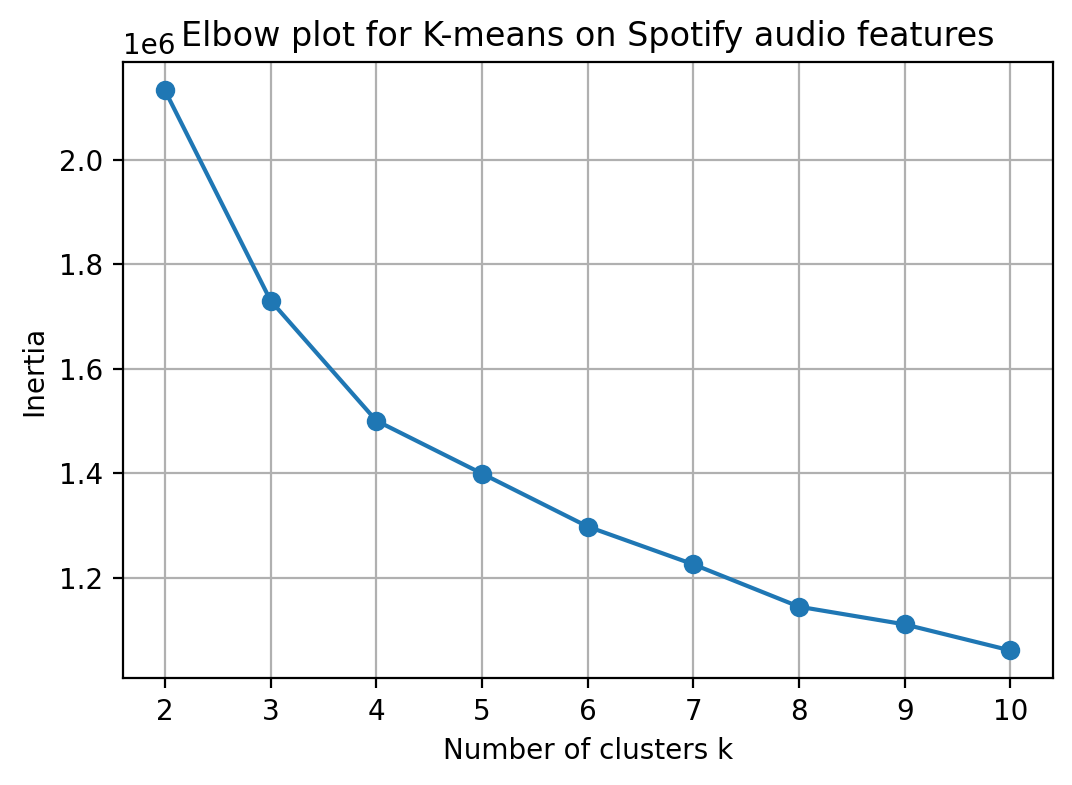

In [5]:
# Plot the inertia/wcss to visualize the elbow
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow plot for K-means on Spotify audio features")
plt.grid(True)
plt.show()

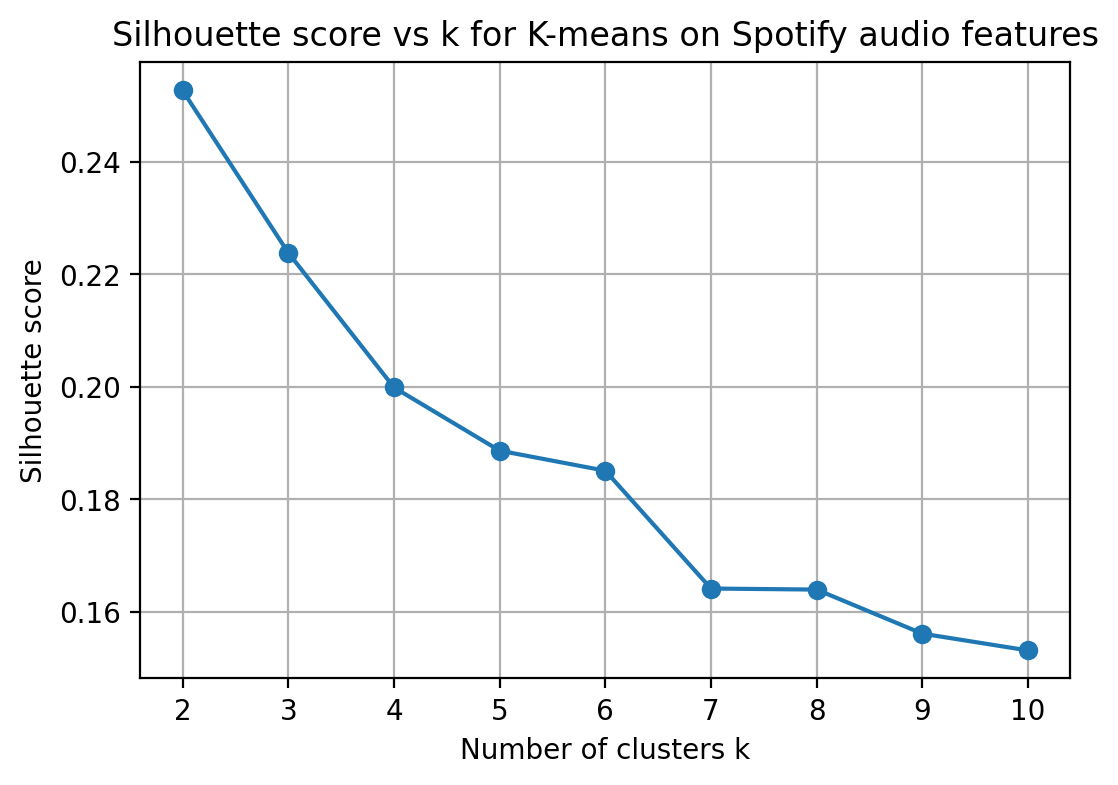

In [6]:
# Plot of the silhouette scores for different k-values
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k for K-means on Spotify audio features")
plt.grid(True)
plt.show()

We have selected k = 3 because it offers the best overall balance between the silhouette score and the elbow method results. At k = 3 the elbow method shows the somewhat meaningful reduction in inertia, while also having the second highest silhouette score, indicating the data is well-assigned to clusters.

## Section 3: Fit K-Means Model

In [12]:
# Chosen K value
BEST_K = 3

cl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('kmeancl', KMeans(n_clusters=BEST_K, random_state=0))
])

# Fit pipeline and get cluster labels
df["cluster_label"] = cl_pipe.fit_predict(X)

print("Cluster label counts:")
print(df["cluster_label"].value_counts().sort_index())

Cluster label counts:
cluster_label
0    194
1    430
2    329
Name: count, dtype: int64


## Section 4: Visualize Clusters

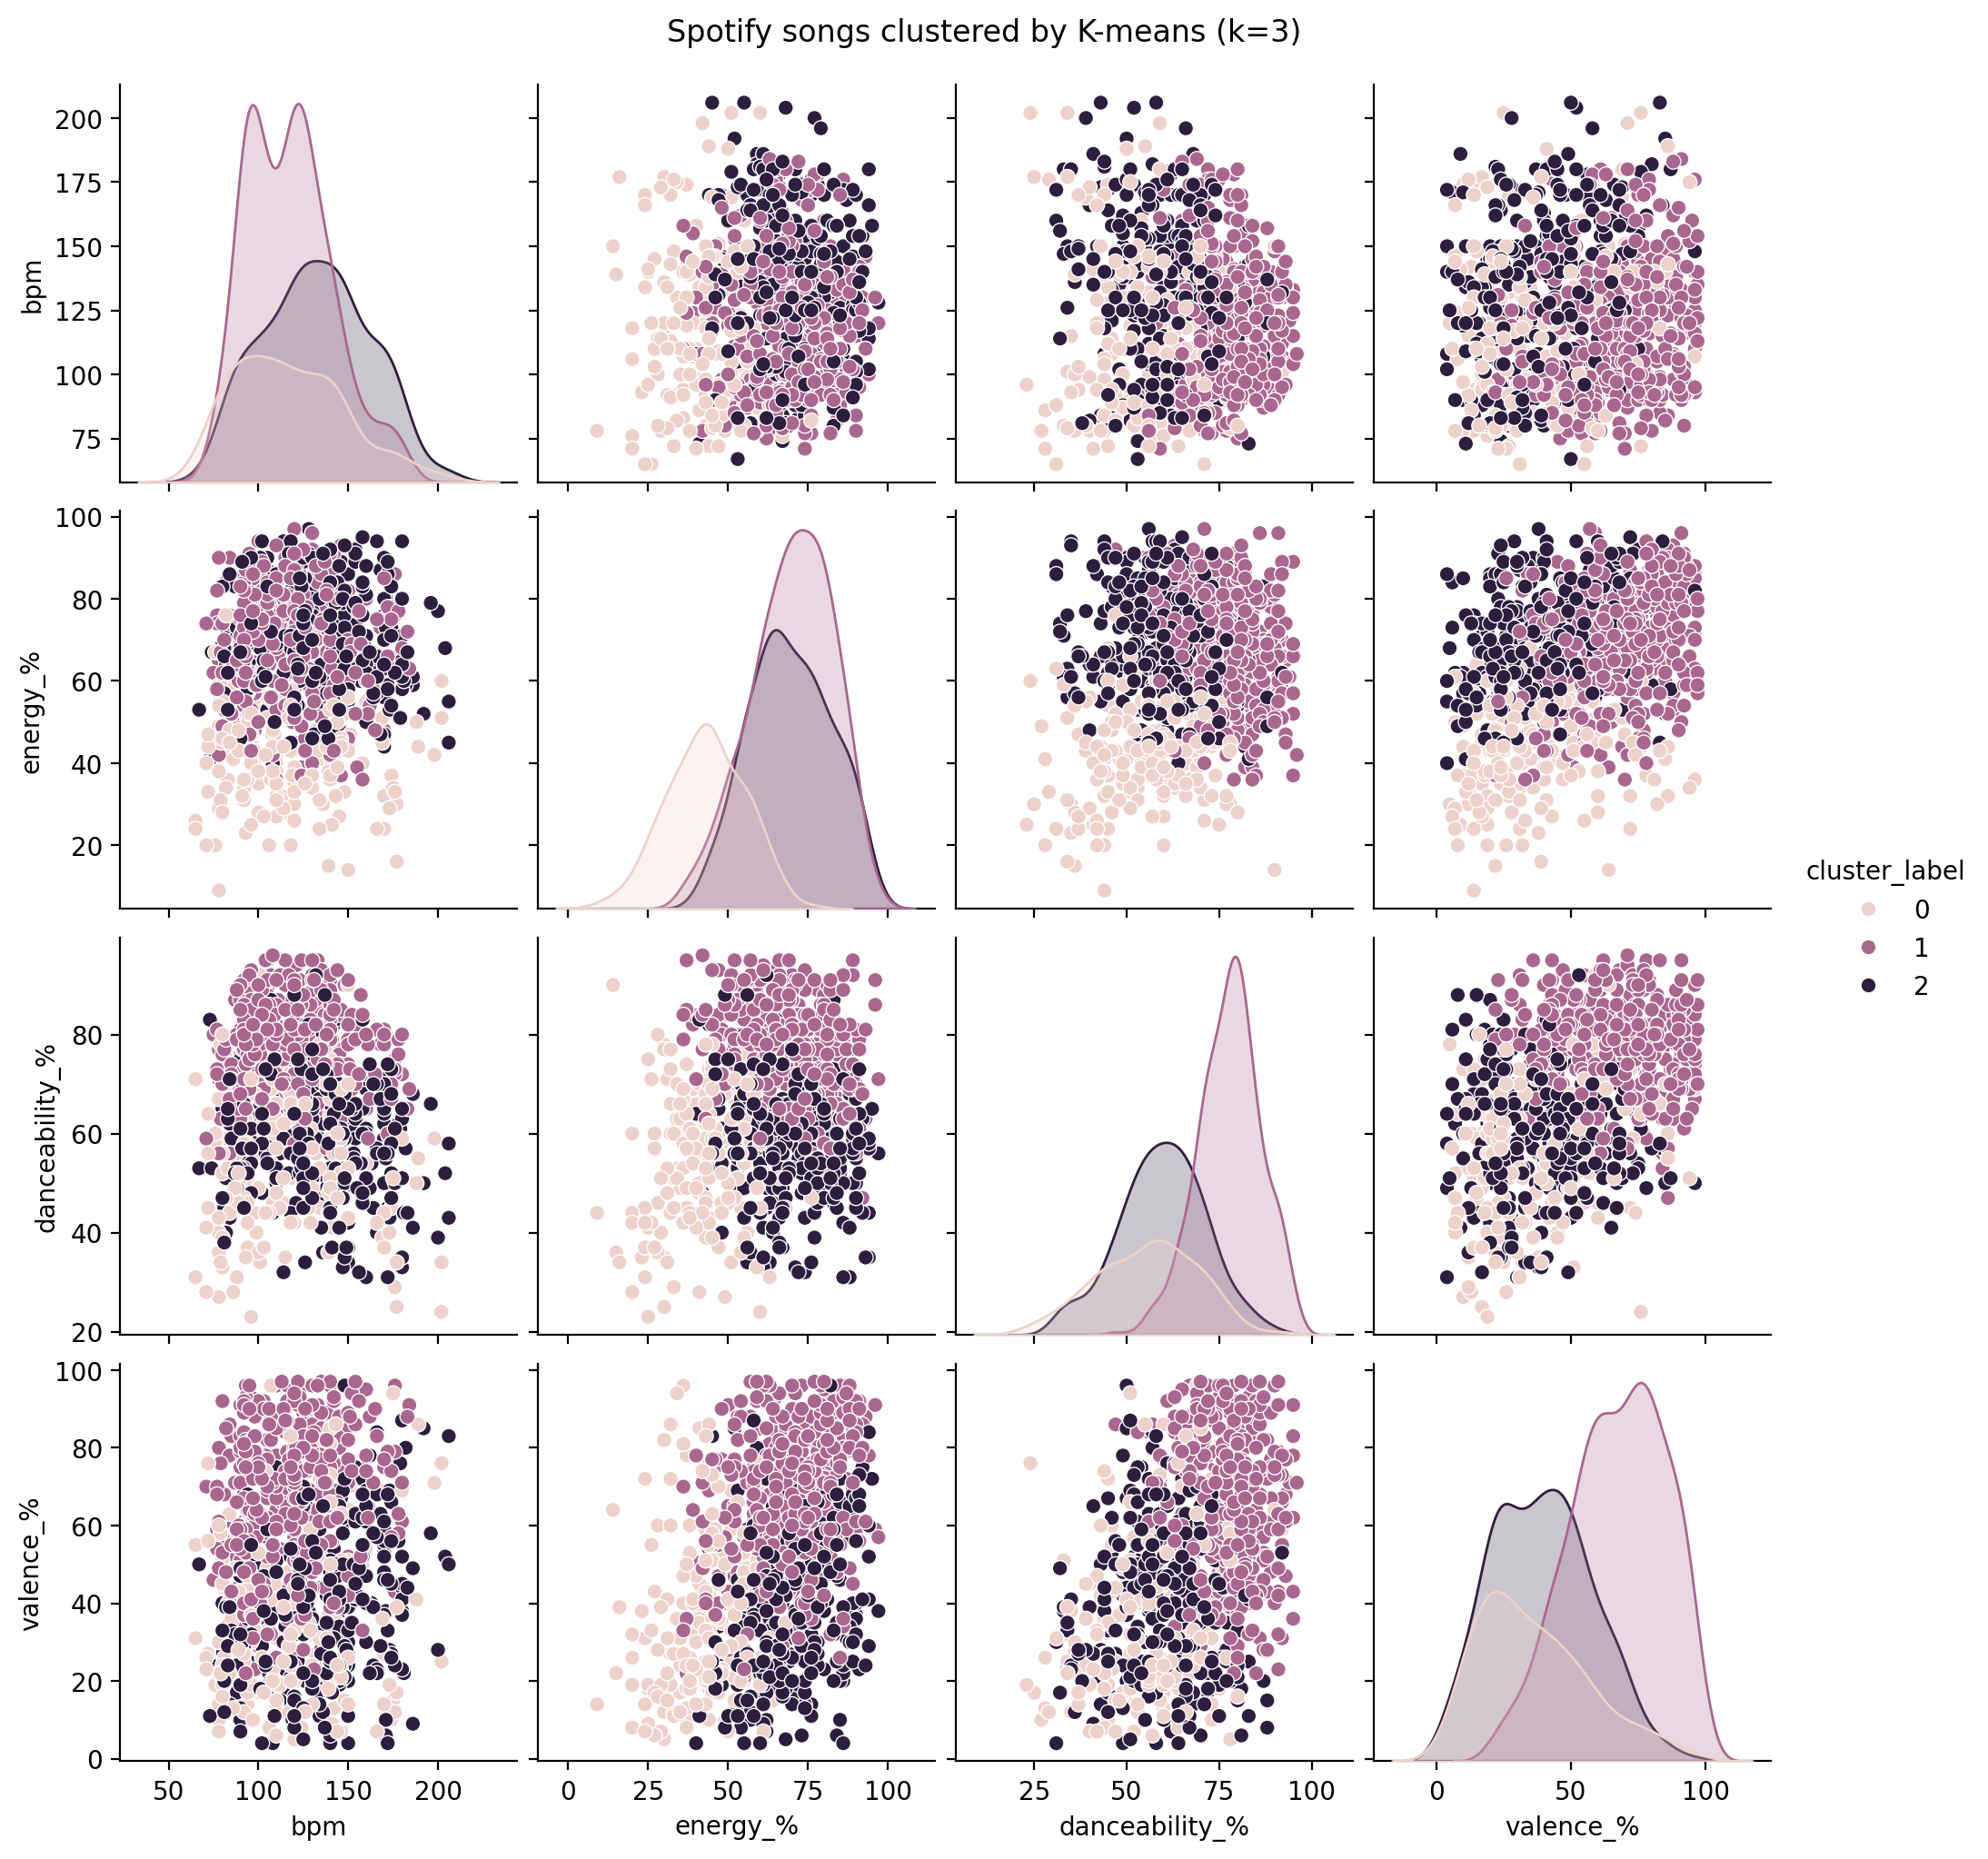

In [13]:
sns.pairplot(
    vars=["bpm", "energy_%", "danceability_%", "valence_%"], 
    hue="cluster_label",
    data=df,
    diag_kind="kde",
)
plt.suptitle(f"Spotify songs clustered by K-means (k={BEST_K})", y=1.02)
plt.show()

We choose the four features bpm, energy, danceability, and valence because they are the most interpretable musically:

- bpm: shows tempo, strongly separates fast vs. slow songs
- energy: high energy vs chill songs
- danceability: groups dance pop songs separately from acoustic songs
- valence: measures "happy vs. sad"
  
These features provide the most interpretable axes for understanding musical similarity, they clearly separate songs by tempo, intensity, rhythm, and mood.

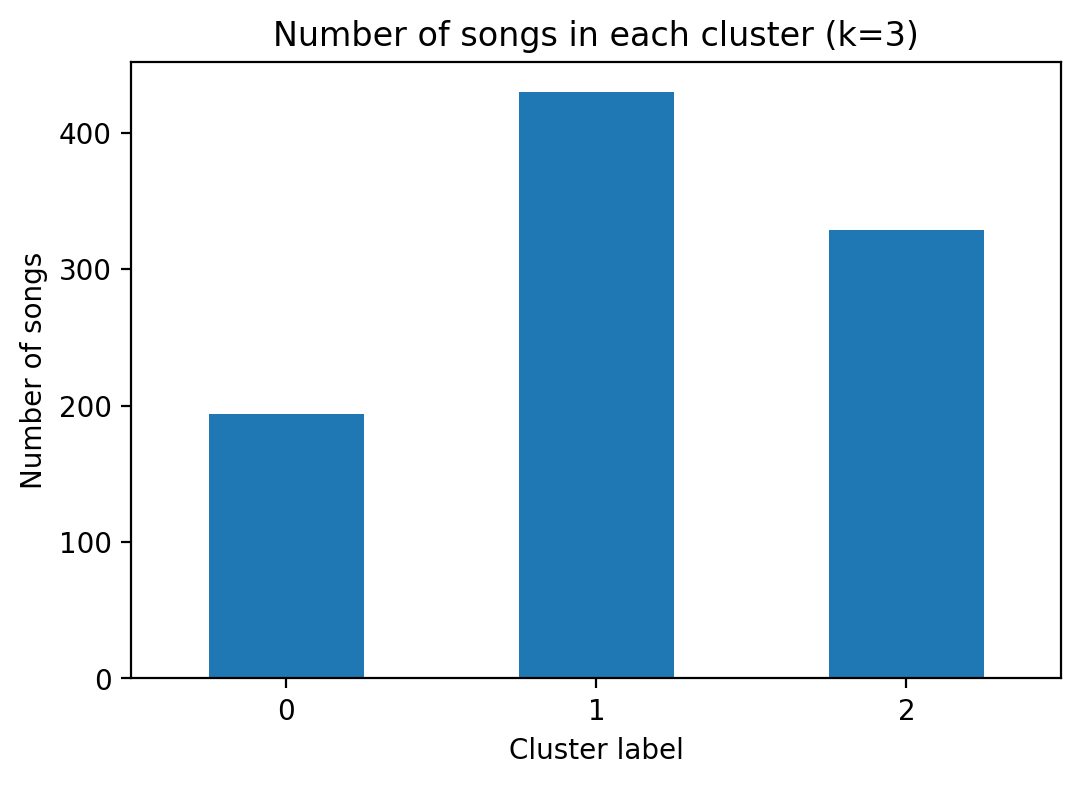

In [14]:
cluster_counts = df["cluster_label"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
cluster_counts.plot(kind="bar")
plt.xlabel("Cluster label")
plt.ylabel("Number of songs")
plt.title(f"Number of songs in each cluster (k={BEST_K})")
plt.xticks(rotation=0)
plt.show()

## Section 5 - Inspect Cluster Results

In [17]:
cluster_summary = df.groupby("cluster_label")[audio_feature_cols].mean()
cluster_summary.head()

,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
cluster_label,,,,,,,,
0,117.458763,55.556701,36.402062,43.015464,64.134021,4.649485,15.994845,7.659794
1,117.348837,77.762791,67.406977,69.900000,21.427907,0.374419,15.620930,12.458140
2,132.322188,59.592705,39.413374,69.471125,12.553191,1.349544,22.908815,8.547112


Cluster 0 - Acoustic/Low-Energy/Emotional & Chill

- High acousticness
- Low energy
- Low valence (more sad)
- Moderate danceability

  
Cluster 1 - High Energy Dance Pop/Happy/Mainstream

- Very high danceability
- High energy
- Highest valence (happy and upbeat)
- Low acousticness

Cluster 2 - Energetic/Edgy/Electronic

- Highest BPM
- High energy
- Low valence
- Low acousticness
- High liveness

## Section 6 - Testing (finding similar songs in the same cluster)

In [24]:
def recommend_similar_songs(spotify_df, audio_features, cl_pipe, seed_track, seed_artist=None, top_n=5):
    
    # Ensure audio_features is a list, not a pandas Index
    audio_features = list(audio_features)

    # Find seed song
    mask = spotify_df["track_name"].str.lower() == seed_track.lower()
    if seed_artist is not None:
        mask &= spotify_df["artist(s)_name"].str.lower().str.contains(seed_artist.lower())
    
    seed_df = spotify_df[mask]
    if seed_df.empty:
        raise ValueError("Seed song not found. Check track name / artist.")
    
    seed_idx = seed_df.index[0]
    seed_cluster = spotify_df.loc[seed_idx, "cluster_label"]
    
    # Filter other songs in same cluster
    same_cluster = spotify_df[
        (spotify_df["cluster_label"] == seed_cluster) &
        (spotify_df.index != seed_idx)
    ]
    if same_cluster.empty:
        raise ValueError("No other songs found in the same cluster.")
    
    # Get scaled features using the scaler from the pipeline
    scaler = cl_pipe.named_steps["scale"]
    X_scaled = scaler.transform(spotify_df[audio_features])

    # Map DataFrame index to position in X_scaled
    index_to_pos = {idx: pos for pos, idx in enumerate(spotify_df.index)}
    
    # Seed vector
    seed_pos = index_to_pos[seed_idx]
    seed_vec = X_scaled[seed_pos]
    
    # Compute distances to songs in same cluster
    distances = []
    for idx in same_cluster.index:
        pos = index_to_pos[idx]
        vec = X_scaled[pos]
        dist = np.linalg.norm(seed_vec - vec)
        distances.append((idx, dist))
    
    # Sort by distance and pick top_n
    distances.sort(key=lambda x: x[1])
    top_indices = [idx for idx, _ in distances[:top_n]]

    cols_to_show = ["track_name", "artist(s)_name", "cluster_label"] + audio_features
    return spotify_df.loc[top_indices, cols_to_show]


#### Test Case: deja vu by Olivia Rodrigo

In [25]:
seed_track = "deja vu"        
seed_artist = "Olivia Rodrigo"   
recs = recommend_similar_songs(
    spotify_df=df,
    audio_features=audio_feature_cols,
    cl_pipe=cl_pipe,
    seed_track=seed_track,
    seed_artist=seed_artist,
    top_n=5
)

print("Seed song:", seed_track, "-", seed_artist)
print("\nRecommended similar songs from the same cluster:")
display(recs)

Seed song: deja vu - Olivia Rodrigo

Recommended similar songs from the same cluster:


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,track_name,artist(s)_name,cluster_label,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
289,Don't ever say love me (feat. RM of BTS),"RM, Colde",2,145,54,19,48,36,0,37,5
173,Demons,Imagine Dragons,2,180,33,38,71,20,0,28,5
651,Boyfriend,Dove Cameron,2,180,35,23,61,23,0,19,6
514,Here We GoÃ¯Â¿Â½Ã¯Â¿Â½Ã¯Â¿Â½ Again (feat. Tyle...,"The Weeknd, Tyler, The Creator",2,135,41,27,64,36,0,60,3
292,Call Out My Name,The Weeknd,2,134,45,17,60,21,0,33,4
